In [1]:
# !pip install pandas==1.3.4
# !pip install mlflow==1.20.2
# !pip install lightgbm==3.3.1
# !pip install matplotlib==3.4.3
# !pip install catboost==1.0.3
# !pip install SQLAlchemy==1.4.25
# !pip install typing-extensions==3.10.0.0
# !pip install prompt-toolkit==3.0.5
# !pip install -r /kfs_private/requirements.txt
# !pip install -i https://test.pypi.org/simple/ kaml==1.0

# !pip install "pyarrow>=4.0.0" --prefer-binary
# !pip uninstall pyspark -y

## import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import base64
import os
import mlflow
from transformations import *

from kaml.client import *
from kaml.classification import *
import json
import base64


## Parameters

In [3]:
pd.set_option('display.max_columns',120)


def decode_py(message):
    base64_bytes = message.encode('ascii')
    message_bytes = base64.b64decode(base64_bytes)
    return message_bytes.decode('ascii')

def encode_py(message):
    message_bytes = message.encode('ascii')
    base64_bytes = base64.b64encode(message_bytes)
    return base64_bytes.decode('ascii')

with open('passcodes.json','r') as f:
    passcodes = json.load(f)
    
# set environment variable
os.environ['MLFLOW_S3_ENDPOINT_URL'] = decode_py(
    passcodes['MLFLOW_S3_ENDPOINT_URL']
)

os.environ['AWS_ACCESS_KEY_ID'] = decode_py(
    passcodes['AWS_ACCESS_KEY_ID']
)

os.environ['AWS_SECRET_ACCESS_KEY'] = decode_py(
    passcodes['AWS_SECRET_ACCESS_KEY']
)

os.environ['MLFLOW_BASE_URL'] = decode_py(
    passcodes['MLFLOW_BASE_URL']
)

mlflow.set_tracking_uri(os.environ['MLFLOW_BASE_URL'])
client = mlflow.tracking.MlflowClient(os.environ['MLFLOW_BASE_URL'])

MINIO_HOST='http://mlflow-minio-service.mlflow.svc.cluster.local:9000'
MINIO_ACCESS_KEY="minio"
MINIO_SECRET_KEY="BS6PpUKnW^Bkc@$l$QAsY$p#l"
MINIO_MODEL_BUCKET="models"

exp_name = "tpl_flg_no_hyrrach"

### Read Parent Complaint file with columns that are filled during a complaint

In [4]:
#complaints_df_1 = pd.read_csv("parent_complaint_file.csv")

In [5]:
#complaints_df_1.columns

### Read Hierarchy Data

In [6]:
#hierarchy_df = pd.read_csv("bp_hierarchy_file.csv")

In [7]:
#complaints_hierarchy_df = pd.read_csv("cmplt_hrchy_file.csv")
cmplts_hrchy_df = pd.read_csv("cmplt_hrchy_file.csv")

In [8]:
cmplts_hrchy_df.columns

Index(['parent_reg_date', 'parent_reg__time', 'parent_complaint_number',
       'parent_business_partner', 'parent_msp_circuit',
       'parent_msp_circuit_description', 'parent_final_obs__code_group',
       'parent_final_obs__code', 'parent_mru', 'parent_industry',
       'parent_industry_system', 'parent_affected_bp',
       'parent_restoration_duration', 'parent_mode', 'parent_regi__group',
       'parent_regi__code', 'parent_rate_category', 'parent_bp_classification',
       'parent_account_class', 'parent_location', 'parent_sub_station',
       'parent_area', 'parent_responsible_zone', 'parent_responsible_dept',
       'parent_zone', 'parent_fsp_circuit', 'parent_fsp_circuit_description',
       'parent_affected_func__location', 'hrcrhy_zone', 'hrcrhy_portion',
       'hrcrhy_business_partner', 'hrcrhy_11kv_oh_feeder_cb',
       'hrcrhy_11kv_ug_feeder_cb', 'hrcrhy_22_kv_feeder',
       'hrcrhy_22_kv_sub_feeder', 'hrcrhy_ht_customer_ss',
       'hrcrhy_dist__sub_station', 'hrcrhy_

### Feature Set Label: New dependent variable: FLG(Functional Location Group)

In [9]:
cmplts_hrchy_df['flg'] = create_label(cmplts_hrchy_df)

In [10]:
cmplts_hrchy_df['flg'].unique()

array(['msp_circuit', 'delivery_point', 'bbc_ahd_', 'dfsp_circuit',
       'ottp', 'fsp_circuit', 'dist_transformer', 'dist__box', 'msp',
       'ht_customer_ss', 'lt_sw_fuse_unit', 'dfsp_sub_circuit',
       'not_in_hierarchy', 'fsp_sub_circuit', 'fsp', 'dfsp',
       'dist__sub_station'], dtype=object)

In [11]:
#cmplts_hrchy_df = complaints_hierarchy_df.copy()
#cmplts_hrchy_df.to_csv("cmplt_hrchy_file.csv",index=False,header=True)

#### Removing those rows whose affected functional location is not in any hirearchical FLG

In [12]:
cmplts_hrchy_df=cmplts_hrchy_df[cmplts_hrchy_df['flg']!='not_in_hierarchy']

In [13]:
cmplts_hrchy_df.shape 

(72038, 55)

## Filling Missing Values

In [14]:
# cmplts_hrchy_df['parent_reg__time'] = cmplts_hrchy_df['parent_reg__time'].fillna('00:00:00')
# cmplts_hrchy_df['parent_rate_category'] = cmplts_hrchy_df['parent_rate_category'].fillna('Non Consumer')
# cmplts_hrchy_df['parent_rate_category'] = cmplts_hrchy_df['parent_rate_category'].apply(lambda x: "_".join(x.lower().split()))

cmplts_hrchy_df['parent_reg__time'] = fill_parent_reg__time(cmplts_hrchy_df)
cmplts_hrchy_df['parent_rate_category'] = fill_parent_rate_category(cmplts_hrchy_df)

cmplts_hrchy_df['parent_area'] = fill_parent_area(cmplts_hrchy_df[['parent_area']])
cmplts_hrchy_df['parent_mru'] = fill_parent_mru(cmplts_hrchy_df[['parent_mru']])

## Format Data

In [15]:
# cmplts_hrchy_df['parent_reg_date_time'] = cmplts_hrchy_df['parent_reg_date'] + " " + cmplts_hrchy_df['parent_reg__time']
# cmplts_hrchy_df['parent_reg_date_time'] = pd.to_datetime(cmplts_hrchy_df['parent_reg_date_time'],format="%d-%m-%Y %H:%M:%S") #format="%d-%m-%Y %H:%M:%S"

cmplts_hrchy_df['parent_reg_date_time'] = format_parent_reg_date(cmplts_hrchy_df)

## Feature Creation

In [16]:
cmplts_hrchy_df = date_time_features(cmplts_hrchy_df,"parent_reg_date_time")

## Historical Feature Creation

**Feature 1: No of times the AFL is affected in past**

In [17]:
#cmplts_hrchy_df['no_of_times_asset_affected'] = no_of_times_asset_affected(cmplts_hrchy_df)

**Feature 2: When was the last time the asset was affected**

In [18]:
#cmplts_hrchy_df['days_when_asset_last_affected'] = days_when_asset_last_affected(cmplts_hrchy_df)

**Feature 3: Number of times hierarchy asset affected in past**

In [19]:
hierarchy_cols = ['hrcrhy_11kv_oh_feeder_cb','hrcrhy_11kv_ug_feeder_cb','hrcrhy_22_kv_feeder','hrcrhy_22_kv_sub_feeder','hrcrhy_ht_customer_ss',
                  'hrcrhy_dist__sub_station','hrcrhy_dist_transformer','hrcrhy_fsp','hrcrhy_fsp_circuit','hrcrhy_fsp_sub_circuit','hrcrhy_dfsp',
                  'hrcrhy_dfsp_circuit','hrcrhy_dfsp_sub_circuit','hrcrhy_msp','hrcrhy_msp_circuit','hrcrhy_otdp','hrcrhy_ottp','hrcrhy_lt_sw_fuse_unit',
                  'hrcrhy_delivery_point','hrcrhy_bbc_ahd_','hrcrhy_dist__box','hrcrhy_device_location']

In [20]:
for col in hierarchy_cols:
    cmplts_hrchy_df = hierarchy_asset_affected(cmplts_hrchy_df,col)

In [21]:
cmplts_hrchy_df['hrcrhy_fsp_circuit'].value_counts()

not-connected            272
A-D-DSC-02259-T1F1C04    118
A-D-DSA-00231-T1F1C03     70
A-D-DSN-01840-T1F1C02     69
A-D-DSC-00061-T1F2C03     67
                        ... 
A-D-DSC-02540-T2F2C05      1
A-D-DSN-00080-T1F1C05      1
A-D-DSA-01197-T1F2C02      1
A-D-DSA-01657-T1F2C04      1
A-D-DSA-00872-T1F2C03      1
Name: hrcrhy_fsp_circuit, Length: 16897, dtype: int64

In [29]:
cmplts_hrchy_df[cmplts_hrchy_df['hrcrhy_device_location_noof_days_before_affected_in_past']>0][['hrcrhy_fsp_circuit','hrcrhy_fsp_circuit_noof_days_before_affected_in_past']]

Empty DataFrame
Columns: [hrcrhy_fsp_circuit, hrcrhy_fsp_circuit_noof_days_before_affected_in_past]
Index: []

In [23]:
for col in hierarchy_cols:
    feature_creation_dict(cmplts_hrchy_df, col,col+"_noof_times_affected_in_past")

**Feature 4: Number of days before a particular asset was affected**

In [24]:
for col in hierarchy_cols:
    cmplts_hrchy_df = noof_days_before_asset_affected(cmplts_hrchy_df,col)

In [166]:
for col in hierarchy_cols:
    feature_creation_dict(cmplts_hrchy_df, col,col+"_noof_days_before_affected_in_past")

**Feature 5: whether customer is HT customer or not**

In [28]:
cmplts_hrchy_df['is_parent_ht_customer'] = is_parent_ht_customer(cmplts_hrchy_df)

**Feature 5: Average of affected BP in past for business partner**

In [29]:
cmplts_hrchy_df['average_affected_bp'] = average_affected_bp(cmplts_hrchy_df)

In [168]:
feature_creation_dict(cmplts_hrchy_df, 'parent_business_partner',"average_affected_bp")

**Feature 6: Median of affected BP in past for business partner**

In [30]:
cmplts_hrchy_df['median_affected_bp_past'] = median_affected_bp_past(cmplts_hrchy_df)

In [169]:
feature_creation_dict(cmplts_hrchy_df, 'parent_business_partner',"median_affected_bp_past")

**Feature 7: Number of complaints in the past for business partner**

In [31]:
cmplts_hrchy_df['no_of_complaints_for_bp_past'] = no_of_complaints_for_bp_past(cmplts_hrchy_df)

In [170]:
feature_creation_dict(cmplts_hrchy_df, 'parent_business_partner',"no_of_complaints_for_bp_past")

**Feature 8: Number of times complaint raised for asset in the past**

In [32]:
for col in hierarchy_cols:
    cmplts_hrchy_df[col+'_no_of_times_comlpt_raised_for_asset'] = no_of_times_comlpt_raised_for_asset(cmplts_hrchy_df,col)

In [171]:
for col in hierarchy_cols:
    feature_creation_dict(cmplts_hrchy_df, col,col+"_no_of_times_comlpt_raised_for_asset")

In [178]:
import joblib
joblib.dump(feature_meta_dict,"feature_meta_dict.joblib")

['feature_meta_dict.joblib']

In [175]:
list(feature_meta_dict.keys())

['hrcrhy_11kv_oh_feeder_cb_noof_times_affected_in_past',
 'hrcrhy_11kv_ug_feeder_cb_noof_times_affected_in_past',
 'hrcrhy_22_kv_feeder_noof_times_affected_in_past',
 'hrcrhy_22_kv_sub_feeder_noof_times_affected_in_past',
 'hrcrhy_ht_customer_ss_noof_times_affected_in_past',
 'hrcrhy_dist__sub_station_noof_times_affected_in_past',
 'hrcrhy_dist_transformer_noof_times_affected_in_past',
 'hrcrhy_fsp_noof_times_affected_in_past',
 'hrcrhy_fsp_circuit_noof_times_affected_in_past',
 'hrcrhy_fsp_sub_circuit_noof_times_affected_in_past',
 'hrcrhy_dfsp_noof_times_affected_in_past',
 'hrcrhy_dfsp_circuit_noof_times_affected_in_past',
 'hrcrhy_dfsp_sub_circuit_noof_times_affected_in_past',
 'hrcrhy_msp_noof_times_affected_in_past',
 'hrcrhy_msp_circuit_noof_times_affected_in_past',
 'hrcrhy_otdp_noof_times_affected_in_past',
 'hrcrhy_ottp_noof_times_affected_in_past',
 'hrcrhy_lt_sw_fuse_unit_noof_times_affected_in_past',
 'hrcrhy_delivery_point_noof_times_affected_in_past',
 'hrcrhy_bbc_ahd__n

In [33]:
#cmplts_hrchy_df.sort_values(by='parent_reg_date_time',inplace=True) 

In [34]:
#cmplts_hrchy_df.to_csv('cmplt_hrchy_all_features.csv',index=False)

### Child data read and merge

In [35]:
child_comp_df =  pd.read_excel("Child Complaint Details.xlsb")

In [36]:
#child_comp_df_csv = pd.read_excel("Child Complaint Details.xlsb")

In [37]:
#child_comp_df_csv.to_csv("only_child_cmplt_file.csv",index=False)

In [38]:
child_comp_df.columns = rename_columns(child_comp_df,prefix="child_")

In [39]:
cmplts_hrchy_chld_df = cmplts_hrchy_df.merge(child_comp_df, left_on=['parent_complaint_number'],right_on=['child_parent_complaint'],how='inner')

## Child Data Cleaning

In [40]:
cmplts_hrchy_chld_df['child_reg_date_time'] = format_child_reg_date(cmplts_hrchy_chld_df)
# child_columns = ['partner_no', 'registration_date', 'registration_time', 'parent_complaint','description','vip_flag']

## Feature Creation

In [41]:
cmplts_hrchy_chld_df = date_time_features(cmplts_hrchy_chld_df,'child_reg_date_time')

In [42]:
cmplts_hrchy_chld_df['time_diff_btwn_child_parent_cmplt'] = time_diff_btwn_child_parent_cmplt(cmplts_hrchy_chld_df)

In [43]:
cmplts_hrchy_chld_df['no_of_past_child_cmplt'] = no_of_past_child_cmplt(cmplts_hrchy_chld_df)

In [44]:
cmplts_hrchy_chld_df['child_vip_flag']=child_vip_flag(cmplts_hrchy_chld_df[['child_vip_flag']])

In [45]:
hierarchy_list = ['hrcrhy_11kv_oh_feeder_cb', 'hrcrhy_11kv_ug_feeder_cb','hrcrhy_22_kv_feeder', 'hrcrhy_22_kv_sub_feeder',
       'hrcrhy_ht_customer_ss', 'hrcrhy_dist__sub_station','hrcrhy_dist_transformer', 'hrcrhy_fsp', 'hrcrhy_fsp_circuit',
       'hrcrhy_fsp_sub_circuit', 'hrcrhy_dfsp', 'hrcrhy_dfsp_circuit','hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp', 'hrcrhy_msp_circuit',
       'hrcrhy_otdp', 'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit','hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box','hrcrhy_device_location']
hierarchy_list.reverse()
def common_hrcrhy_level_of_child_parent(df):
    return list(map(lambda x: x, filter(lambda y: str(df[y+"_parent"]) == str(df[y+"_child"]),hierarchy_list)))[0]
    #hierarchy_temp_df = hierarchy_df[hierarchy_df['hrcrhy_business_partner']==df['child_partner_no']]
#     if not hierarchy_temp_df.empty:
#         return list(map(lambda x: x, filter(lambda y: str(df[y+"_parent"]) == df[y+"_child"].values[0],hierarchy_list)))[0]
#     else:
#         return np.NaN
#     for i in hierarchy_list:
#         if hierarchy_temp_df[i].empty:
#             return np.NaN
#         if str(df[i]) == hierarchy_temp_df[i].values[0]:
#             return i
#     return np.NaN

# temp_child_hrrcy = cmplts_hrchy_chld_df.merge(hierarchy_df,left_on='child_partner_no',right_on='hrcrhy_business_partner',suffixes=('_parent','_child'))
# temp_child_hrrcy.apply(common_hrcrhy_level_of_child_parent,axis=1).unique()

In [47]:
##cmplts_hrchy_chld_df.to_csv("child_cmplt_hrchy.csv",index=False)

In [48]:
##cmplts_hrchy_chld_df=pd.read_csv("child_cmplt_hrchy.csv")

## Split Train, Test and Validation Data

In [49]:
## train_data = complaints_hierarchy_df[complaints_hierarchy_df['reg_date_time'] < pd.to_datetime('2021-07-01')]
## validation_data = complaints_hierarchy_df[(complaints_hierarchy_df['reg_date_time'] >= pd.to_datetime('2021-07-01')) & (complaints_hierarchy_df['reg_date_time'] < pd.to_datetime('2021-10-01'))]
## test_data = complaints_hierarchy_df[complaints_hierarchy_df['reg_date_time'] >= pd.to_datetime('2021-10-01')]

### Taking only 1st year data for training where number of child complaints > cmplnt_fmly_crtcl_mass

In [50]:
from sklearn.model_selection import train_test_split

train_val_data_all_cmplt = cmplts_hrchy_chld_df[pd.to_datetime(cmplts_hrchy_chld_df['parent_reg_date_time']) < pd.to_datetime('2021-10-01')]
test_data = cmplts_hrchy_chld_df[pd.to_datetime(cmplts_hrchy_chld_df['parent_reg_date_time']) >= pd.to_datetime('2021-10-01')]



In [51]:
cmplnt_fmly_crtcl_mass =2

In [52]:
#train_val_data = train_val_data[train_val_data.groupby('complaint_number').size()>cmplnt_fmly_crtcl_mass]

train_val_data = train_val_data_all_cmplt[train_val_data_all_cmplt.groupby(['parent_complaint_number'])['child_partner_no'].transform('count')>cmplnt_fmly_crtcl_mass]

In [53]:
train_data = train_val_data.groupby(['parent_complaint_number']).apply(lambda x: x.head(cmplnt_fmly_crtcl_mass)).reset_index(drop=True)

In [54]:
val_data = train_val_data.groupby(['parent_complaint_number']).apply(lambda x: x.iloc[cmplnt_fmly_crtcl_mass:,:]).reset_index(drop=True)

In [55]:
from sklearn.model_selection import train_test_split
# train_data, validation_data = train_test_split(train_val_data,test_size=0.2,random_state=42)

In [56]:
#train_val_data, test_data = train_test_split(cmplts_hrchy_chld_df,test_size=0.2,random_state=42)
#train_data, val_data = train_test_split(train_val_data,test_size=0.2,random_state=42)

In [57]:
print("Train Data : ", train_data.shape)
print("Validation Data : ", val_data.shape)
print("Test Data : ", test_data.shape)

Train Data :  (14196, 292)
Validation Data :  (7524, 292)
Test Data :  (2383, 292)


In [58]:
train_data['flg'].value_counts()

fsp_circuit          6690
delivery_point       2014
msp_circuit          1722
msp                  1344
dist_transformer      652
ottp                  464
fsp_sub_circuit       320
dfsp_circuit          274
lt_sw_fuse_unit       214
fsp                   140
bbc_ahd_              134
dist__box             112
dfsp_sub_circuit       68
dfsp                   40
dist__sub_station       8
Name: flg, dtype: int64

In [59]:
l = train_data.columns[~train_data.columns.str.contains("hrcrhy_")]
train_data[train_data['flg']=='delivery_point'][l].head()

parent_reg_date parent_reg__time parent_complaint_number  \
8       02-12-2019         13:04:00              1004749034   
9       02-12-2019         13:04:00              1004749034   
20      07-12-2019         13:42:00              1004756773   
21      07-12-2019         13:42:00              1004756773   
30      08-12-2019         20:05:00              1004758522   

    parent_business_partner       parent_msp_circuit  \
8                    274280  A-D-MSPDU-0151-197-MC04   
9                    274280  A-D-MSPDU-0151-197-MC04   
20                    63541   A-D-MSPC-0166-193-MC08   
21                    63541   A-D-MSPC-0166-193-MC08   
30                   532617   A-D-MSPC-0170-079-MC04   

   parent_msp_circuit_description parent_final_obs__code_group  \
8                   MSP CKT-10_4C         L.T Cable Fault work   
9                   MSP CKT-10_4C         L.T Cable Fault work   
20                  MSP CKT-10_2C         L.T Cable Fault work   
21                  MSP CKT-10_2C         L.T Cable Fault work   
30                  MSP CKT-25_4C         L.T Cable Fault work   

   parent_final_obs__code parent_mru parent_industry parent_industry_system  \
8     Looping Cable Fault   OZ120709             NaN                    NaN   
9     Looping Cable Fault   OZ120709             NaN                    NaN   
20    Looping Cable Fault   OZ020859             NaN                    NaN   
21    Looping Cable Fault   OZ020859             NaN                    NaN   
30    Looping Cable Fault   OZ020808             NaN                    NaN   

    parent_affected_bp  parent_restoration_duration parent_mode  \
8                    1                          166        IVRS   
9                    1                          166        IVRS   
20                   4                          288        IVRS   
21                   4                          288        IVRS   
30                   2                          150        IVRS   

   parent_regi__group parent_regi__code  \
8       Power Related          NO POWER   
9       Power Related          NO POWER   
20      Power Related          NO POWER   
21      Power Related          NO POWER   
30      Power Related          NO POWER   

                        parent_rate_category parent_bp_classification  \
8   commercial_general_purpose_rate_category               Commercial   
9   commercial_general_purpose_rate_category               Commercial   
20      residential_general_purpose_category              Residential   
21      residential_general_purpose_category              Residential   
30      residential_general_purpose_category              Residential   

   parent_account_class parent_location          parent_sub_station  \
8          LT Ahmedabad         D-CZ-11         GUJARAT GINNING-PMT   
9          LT Ahmedabad         D-CZ-11         GUJARAT GINNING-PMT   
20         LT Ahmedabad         D-CZ-02       33KV SHAHPUR CSS-1 SS   
21         LT Ahmedabad         D-CZ-02       33KV SHAHPUR CSS-1 SS   
30         LT Ahmedabad         D-CZ-02  ASOPALAV APPT (KHANPUR)-SS   

          parent_area parent_responsible_zone parent_responsible_dept  \
8   Girdharnagar Area              Dudheshwar                  DU-NPC   
9   Girdharnagar Area              Dudheshwar                  DU-NPC   
20      Jubilee House              Dudheshwar                  DU-NPC   
21      Jubilee House              Dudheshwar                  DU-NPC   
30            Khanpur              Dudheshwar                  DU-NPC   

   parent_zone      parent_fsp_circuit  \
8        OZ002   A-D-DSC-00351-T1F1C03   
9        OZ002   A-D-DSC-00351-T1F1C03   
20       OZ002  A-D-DSDU-00455-T1F4C03   
21       OZ002  A-D-DSDU-00455-T1F4C03   
30       OZ002   A-D-DSC-00115-T1F1C02   

            parent_fsp_circuit_description parent_affected_func__location  \
8           GUJARAT GINNING-TR-FSP-1 CKT-3                 A-D-DPC-038451   
9           GUJARAT GINNING-TR-FSP-1 CKT-

## Drop Un-used features

In [60]:
child_cmplt_feat = ['portion','mru','object_id','regio_group','name','address','registration_date','registration_time','area',
 'affected_fl','affected_fl_count','allocation_date','allocation_time','allocation_duration',
 'attending_date','attending_time','attending_duration','created_by','diverted_dept','diverted_zone','faultman','faultman_id',
 'mode','responsible_dept','responsible_zone','status','system_condition','technician_remark','temp_date','temp_time','perm_date',
 'perm_time','temp_duration','perm_duration','observation_codegroup','observation_code','final_observation_codegroup_mains_',
 'final_observation_code_mains_','category_1','category_2','power_restoration','mobile_no','sub_station','sub_station_name','feeder',
 'feeder_name','notification_no_yz_','location','planner_group','work_center','note1','note2','gross__duration','compliance_duration',
 'restoration_duration__min_','atteding_dur_from_allocation','within_internal_benchmark','internal_benchmark_def','npc_compliance',
 'neg_ind','final_observation','final_observation_code','complaint_group','rnpc_complaint','solved_by_rnpc','damage_memo_amt',
 'old_categ_1','old_categ_2','power_on_site','dtc_code','dtc_name','delivery_point','del_name','meter_no','service_status','repeat_call',
 'rnpc_visit_id','rnpc_visit_name','rate_cateogry','sanction_load','connected_load','bill_class','phase','mf','attended_user_id',
 'attended_user_name','mobile_no_1','mobile_no_2','notification_no_y9_','pending_in_minute','hv_notification','compliance_st_date',
 'compliance_st_time','compliance_end_date','compliance_end_time','diverted_date','diverted_time','reading_seq_no','legacy_seq_no',
 'direction','old_info','theft_ind','master_mobile_no_1','master_mobile_no_2','master_mobile_no_3','master_mobile_no_4','first_allocation_date',
 'first_allocation_time','actual_completion_date','actual_completion_time','creator_zone','creator_dept','npc_compliance_reason',
 'npc_compliance_reason_1','entered_attending_date','entered_attending_time','complainer_name','changed_by','changed_from',
 'act_comp_st_date','act_comp_st_time','act_comp_en_date','act_comp_en_time','old_tech_remark','amp_rating',
 'cause_code_group','cause_code','damage_code_group','damage_code','object_code_group','object_code','ckt_phase',
 'same_circuit_npc','last_reading','last_reading_date','manufacturer_serial_no','allocated_user_id','allocated_user_name','service_category']

In [61]:
child_cmplt_feat = ["child_"+x for x in child_cmplt_feat]

In [62]:
drop_columns = ['parent_reg__time','parent_industry','parent_industry_system','parent_reg_date','parent_reg_date_time','child_reg_date_time','parent_affected_bp','parent_restoration_duration','parent_final_obs__code','parent_msp_circuit_description','parent_affected_func__location','hrcrhy_count',
               'parent_fsp_circuit_description','parent_mode','parent_responsible_zone','parent_responsible_dept','child_portion',
                'parent_final_obs__code_group','child_description','days_when_asset_last_affected',
 'no_of_times_asset_affected',]+child_cmplt_feat

In [63]:
train_data.drop(drop_columns,axis=1,inplace=True)
val_data.drop(drop_columns,axis=1,inplace=True)
test_data.drop(drop_columns,axis=1,inplace=True)

## Label Encode

In [64]:
label_encode_list = ['parent_msp_circuit','parent_fsp_circuit','parent_account_class','parent_mru','parent_location','parent_regi__group','parent_regi__code','parent_rate_category','parent_bp_classification',
                    'parent_area','parent_regi__group','hrcrhy_11kv_oh_feeder_cb','hrcrhy_11kv_ug_feeder_cb', 'hrcrhy_22_kv_feeder','hrcrhy_22_kv_sub_feeder', 'hrcrhy_dist__sub_station',
                    'hrcrhy_dist_transformer', 'hrcrhy_fsp','parent_sub_station','parent_zone','hrcrhy_dfsp', 'hrcrhy_otdp','hrcrhy_ht_customer_ss','hrcrhy_fsp_circuit',
                    'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit', 'hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box','hrcrhy_portion','hrcrhy_zone',
                    'hrcrhy_device_location','hrcrhy_dfsp_circuit', 'hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp','hrcrhy_fsp_sub_circuit','hrcrhy_msp_circuit',]

In [65]:
label_encoding_fit(train_data,label_encode_list)

In [66]:
train_data= label_encoding_transfrom(train_data)
val_data=label_encoding_transfrom(val_data)
test_data=label_encoding_transfrom(test_data)

#### LabelEncode

In [67]:
train_data['flg'] = label_mapping(train_data[['flg']])
val_data['flg'] = label_mapping(val_data[['flg']])
test_data['flg'] = label_mapping(test_data[['flg']])

## Feature Selection

In [68]:
#train_data.to_csv("child_train_data.csv",index=False)

In [69]:
#val_data.to_csv("child_val_data.csv",index=False)

In [70]:
#test_data.to_csv("child_test_data.csv",index=False)

In [71]:
#train_data = pd.read_csv("child_train_data.csv")

In [72]:
#val_data = pd.read_csv("child_val_data.csv")

In [73]:
#test_data= pd.read_csv("child_test_data.csv")

## remove hierarchy features

In [74]:
hierarchy_list = ['hrcrhy_11kv_oh_feeder_cb', 'hrcrhy_11kv_ug_feeder_cb','hrcrhy_22_kv_feeder', 'hrcrhy_22_kv_sub_feeder',
       'hrcrhy_ht_customer_ss', 'hrcrhy_dist__sub_station','hrcrhy_dist_transformer', 'hrcrhy_fsp', 'hrcrhy_fsp_circuit',
       'hrcrhy_fsp_sub_circuit', 'hrcrhy_dfsp', 'hrcrhy_dfsp_circuit','hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp', 'hrcrhy_msp_circuit',
       'hrcrhy_otdp', 'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit','hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box','hrcrhy_device_location']

In [75]:
id_columns = ["parent_complaint_number","parent_business_partner",'child_partner_no','child_parent_complaint','hrcrhy_business_partner']
use_cols = list(set(train_data.columns) - set(id_columns) - set(hierarchy_list))

## Univarient Features selection

In [76]:
sel_cols = univarient_selection(train_data[use_cols])

## Correlation Features selection

In [77]:
sel_cols = correlation_feature_elemination(train_data[sel_cols],corr_factor=0.8)

In [78]:
label ='flg'

In [79]:
X_train = train_data[sel_cols].drop(label,axis=1)
y_train = train_data[label]
X_val =  val_data[sel_cols].drop(label,axis=1)
y_val =  val_data[label]
 

## Mutual Info feature selection

In [80]:
top_features_mu_info = mutual_info_score(X_train,y_train)

In [81]:
top_features_mu_info

['parent_fsp_circuit',
 'parent_mru',
 'parent_msp_circuit',
 'parent_sub_station',
 'hrcrhy_ottp_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_dfsp_circuit_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_dist__box_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_lt_sw_fuse_unit_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_bbc_ahd__no_of_times_comlpt_raised_for_asset',
 'parent_area',
 'hrcrhy_portion',
 'parent_location',
 'hrcrhy_fsp_circuit_noof_days_before_affected_in_past',
 'hrcrhy_msp_circuit_no_of_times_comlpt_raised_for_asset',
 'time_diff_btwn_child_parent_cmplt',
 'hrcrhy_11kv_ug_feeder_cb_no_of_times_comlpt_raised_for_asset',
 'average_affected_bp',
 'parent_zone',
 'hrcrhy_dist_transformer_noof_days_before_affected_in_past',
 'hrcrhy_dist__sub_station_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_msp_circuit_noof_days_before_affected_in_past']

## Recursive Feature Engineering

In [82]:
top_features_rfe = recursive_feature_engineering(X_train, y_train)

In [83]:
top = top_features_rfe
top

['child_reg_date_time_day',
 'parent_fsp_circuit',
 'time_diff_btwn_child_parent_cmplt',
 'hrcrhy_fsp_circuit_noof_times_affected_in_past',
 'hrcrhy_ottp_no_of_times_comlpt_raised_for_asset',
 'parent_reg_date_time_minute',
 'parent_location',
 'hrcrhy_fsp_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_msp_circuit_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_fsp_sub_circuit_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_dfsp_circuit_no_of_times_comlpt_raised_for_asset',
 'parent_zone',
 'parent_sub_station',
 'parent_area',
 'hrcrhy_portion',
 'hrcrhy_dist__sub_station_no_of_times_comlpt_raised_for_asset',
 'parent_msp_circuit',
 'parent_reg_date_time_hour',
 'parent_mru',
 'hrcrhy_11kv_ug_feeder_cb_no_of_times_comlpt_raised_for_asset']

In [84]:
train_data[top+[label]].corr()[label].abs().sort_values()

child_reg_date_time_day                                         0.004430
hrcrhy_11kv_ug_feeder_cb_no_of_times_comlpt_raised_for_asset    0.009829
hrcrhy_fsp_no_of_times_comlpt_raised_for_asset                  0.013808
parent_reg_date_time_minute                                     0.019791
hrcrhy_dist__sub_station_no_of_times_comlpt_raised_for_asset    0.021426
parent_area                                                     0.022140
hrcrhy_portion                                                  0.025040
parent_reg_date_time_hour                                       0.031725
parent_location                                                 0.038670
hrcrhy_fsp_sub_circuit_no_of_times_comlpt_raised_for_asset      0.046095
parent_mru                                                      0.060478
parent_fsp_circuit                                              0.063311
hrcrhy_dfsp_circuit_no_of_times_comlpt_raised_for_asset         0.073872
parent_sub_station                                 

In [85]:
X_train = train_data[top]
y_train = train_data[label]

X_val = val_data[top]
y_val = val_data[label]

## PCA

In [86]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=5)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_val = pca.transform(X_val)
# #X_test = pca.transform(X_test)

In [87]:
# pca.explained_variance_ratio_

In [88]:
# X_test =  test_data[sel_cols].drop(label,axis=1)
# y_test =  test_data[label]
# X_test = pca.transform(X_test)

## Shaply

In [89]:
# import shap
# from xgboost import XGBClassifier
# model = XGBClassifier(n_estimators=1000, max_depth=10,learning_rate=0.001)
# model.fit(X_train,y_train)

# shap.initjs()
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_val)

In [90]:
# i = 10
# shap.force_plot(explainer.expected_value,shap_values[i], features=X_test.iloc[i], features_names=X_test.columns)

In [91]:
# shap.summary_plot(shap_values, features=X_val, feature_names=X_val.columns)

In [92]:
# shap.summary_plot(shap_values, features=X_val, feature_name=X_val.columns, plot_type='bar')

## Modelling

In [93]:
clf = Classifier(X_train,X_val,y_train,y_val, exp_name, multiclass=True, average="weighted")

In [94]:
exp_id = clf.id
print("experiment name : ",clf.name)
print("experiment location : ",clf.location)
print("experiment id : ",clf.id)
print("experiment status : ",clf.stage)

experiment name :  tpl_flg_no_hyrrach
experiment location :  s3://models/3
experiment id :  3
experiment status :  active


In [95]:
run_list = clf.search_runs(exp_id)['run_id'].tolist()
if run_list:
    clf.delete_run_by_id(run_list)

In [96]:
clf.LogisticRegression()

In [97]:
clf.GradientBoostingClassifier()

In [98]:
clf.RandomForestClassifier()

In [99]:
clf.AdaBoostClassifier()

In [100]:
clf.LGBMClassifier()

In [101]:
clf.XGBClassifier()

[13:05:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [102]:
clf.DecisionTreeClassifier()

In [103]:
clf.RidgeClassifier()

In [104]:
clf.KNeighborsClassifier()

In [105]:
clf.GaussianNB()

In [106]:
clf.CatBoostClassifier()

Learning rate set to 0.090591
0:	learn: 2.3952754	total: 76.4ms	remaining: 1m 16s
1:	learn: 2.2285426	total: 119ms	remaining: 59.2s
2:	learn: 2.1097768	total: 143ms	remaining: 47.6s
3:	learn: 2.0104875	total: 168ms	remaining: 41.8s
4:	learn: 1.9331831	total: 194ms	remaining: 38.5s
5:	learn: 1.8764095	total: 220ms	remaining: 36.5s
6:	learn: 1.8199339	total: 258ms	remaining: 36.6s
7:	learn: 1.7715156	total: 292ms	remaining: 36.3s
8:	learn: 1.7349536	total: 318ms	remaining: 35s
9:	learn: 1.6974192	total: 346ms	remaining: 34.2s
10:	learn: 1.6657091	total: 372ms	remaining: 33.5s
11:	learn: 1.6399998	total: 402ms	remaining: 33.1s
12:	learn: 1.6157323	total: 428ms	remaining: 32.5s
13:	learn: 1.5929908	total: 455ms	remaining: 32s
14:	learn: 1.5718723	total: 482ms	remaining: 31.6s
15:	learn: 1.5545749	total: 507ms	remaining: 31.2s
16:	learn: 1.5372421	total: 538ms	remaining: 31.1s
17:	learn: 1.5174865	total: 563ms	remaining: 30.7s
18:	learn: 1.5048491	total: 588ms	remaining: 30.4s
19:	learn: 1.

## Get runs

In [107]:
# Select the run of the experiment
df_runs = clf.search_runs(clf.id)
print("Number of runs done : ", len(df_runs))
df_runs.head()

Number of runs done :  11


artifact_uri  \
0  s3://models/3/5a2aabe3d124444ab0bd8a22f3dcfe37...   
1  s3://models/3/4819e751bbd54804b8e8778753784d0c...   
2  s3://models/3/4261b95b39f1456497f36aeaa6b28778...   
3  s3://models/3/7a8cc7bdeb054b1ab5d68d3774ba1b03...   
4  s3://models/3/1cb61161c40e44328f437b689d4218e0...   

                          end_time experiment_id  metrics.accuracy_score  \
0 2022-03-02 13:06:42.399000+00:00             3                0.958001   
1 2022-03-02 13:06:11.420000+00:00             3                0.164274   
2 2022-03-02 13:06:09.836000+00:00             3                0.670654   
3 2022-03-02 13:06:06.319000+00:00             3                0.506778   
4 2022-03-02 13:06:04.596000+00:00             3                0.791334   

   metrics.f1_score  metrics.precision_score  metrics.recall  \
0          0.957808                 0.959750        0.958001   
1          0.126085                 0.479487        0.164274   
2          0.646107                 0.667805        0.670654   
3          0.382755                 0.356927        0.506778   
4          0.794626                 0.803427        0.791334   

                             run_id  \
0  5a2aabe3d124444ab0bd8a22f3dcfe37   
1  4819e751bbd54804b8e8778753784d0c   
2  4261b95b39f1456497f36aeaa6b28778   
3  7a8cc7bdeb054b1ab5d68d3774ba1b03   
4  1cb61161c40e44328f437b689d4218e0   

                                        run_name  \
0      tpl_flg_no_hyrrach_3_cat_boost_classifier   
1    tpl_flg_no_hyrrach_3_gaussian_NB_classifier   
2    tpl_flg_no_hyrrach_3_k_neighbors_classifier   
3          tpl_flg_no_hyrrach_3_ridge_classifier   
4  tpl_flg_no_hyrrach_3_decision_tree_classifier   

                        start_time    status  \
0 2022-03-02 13:06:11.436000+00:00  FINISHED   
1 2022-03-02 13:06:09.852000+00:00  FINISHED   
2 2022-03-02 13:06:06.335000+00:00  FINISHED   
3 2022-03-02 13:06:04.612000+00:00  FINISHED   
4 2022-03-02 13:06:02.698000+00:00  FINISHED   

                       tags.mlflow.log-model.history  
0  [{"run_id": "5a2aabe3d124444ab0bd8a22f3dcfe37"...  
1  [{"run_id": "4819e751bbd54804b8e8778753784d0c"...  
2  [{"run_id": "4261b95b39f1456497f36aeaa6b28778"...  
3  [{"run_id": "7a8cc7bdeb054b1ab5d68d3774ba1b03"...  
4  [{"run_id": "1cb61161c40e44328f437b689d4218e0"...

## Evaluating  Models

In [108]:
top_runs = df_runs.sort_values(['metrics.f1_score'],ascending=False)
top_runs.head()

artifact_uri  \
5  s3://models/3/616835a98502459b8ea3b1a6d7a2fd45...   
8  s3://models/3/4a04acb34947456fa833422978dce6ae...   
0  s3://models/3/5a2aabe3d124444ab0bd8a22f3dcfe37...   
6  s3://models/3/9664b9759af94db3bbf2ba5cc15ebe0c...   
4  s3://models/3/1cb61161c40e44328f437b689d4218e0...   

                          end_time experiment_id  metrics.accuracy_score  \
5 2022-03-02 13:06:02.675000+00:00             3                0.975013   
8 2022-03-02 13:05:40.172000+00:00             3                0.973684   
0 2022-03-02 13:06:42.399000+00:00             3                0.958001   
6 2022-03-02 13:05:49.109000+00:00             3                0.790670   
4 2022-03-02 13:06:04.596000+00:00             3                0.791334   

   metrics.f1_score  metrics.precision_score  metrics.recall  \
5          0.975057                 0.975794        0.975013   
8          0.973785                 0.974829        0.973684   
0          0.957808                 0.959750        0.958001   
6          0.799298                 0.818821        0.790670   
4          0.794626                 0.803427        0.791334   

                             run_id  \
5  616835a98502459b8ea3b1a6d7a2fd45   
8  4a04acb34947456fa833422978dce6ae   
0  5a2aabe3d124444ab0bd8a22f3dcfe37   
6  9664b9759af94db3bbf2ba5cc15ebe0c   
4  1cb61161c40e44328f437b689d4218e0   

                                        run_name  \
5            tpl_flg_no_hyrrach_3_xgb_classifier   
8  tpl_flg_no_hyrrach_3_random_forest_classifier   
0      tpl_flg_no_hyrrach_3_cat_boost_classifier   
6           tpl_flg_no_hyrrach_3_lgbm_classifier   
4  tpl_flg_no_hyrrach_3_decision_tree_classifier   

                        start_time    status  \
5 2022-03-02 13:05:49.138000+00:00  FINISHED   
8 2022-03-02 13:05:34.158000+00:00  FINISHED   
0 2022-03-02 13:06:11.436000+00:00  FINISHED   
6 2022-03-02 13:05:43.113000+00:00  FINISHED   
4 2022-03-02 13:06:02.698000+00:00  FINISHED   

                       tags.mlflow.log-model.history  
5  [{"run_id": "616835a98502459b8ea3b1a6d7a2fd45"...  
8  [{"run_id": "4a04acb34947456fa833422978dce6ae"...  
0  [{"run_id": "5a2aabe3d124444ab0bd8a22f3dcfe37"...  
6  [{"run_id": "9664b9759af94db3bbf2ba5cc15ebe0c"...  
4  [{"run_id": "1cb61161c40e44328f437b689d4218e0"...

## Selecting best model

In [109]:
artifacts = top_runs.iloc[0]["artifact_uri"]
run_id = top_runs.iloc[0]["run_id"]
model_name = top_runs.iloc[0]["run_name"] 


print('Best model_artifacts :',artifacts)
print("=" * 100)
print('Best model run_id :',run_id)
print("=" * 100)
print('Best model :',model_name)
print("=" * 100)
print("Best model experiment id :",clf.id)

Best model_artifacts : s3://models/3/616835a98502459b8ea3b1a6d7a2fd45/artifacts
Best model run_id : 616835a98502459b8ea3b1a6d7a2fd45
Best model : tpl_flg_no_hyrrach_3_xgb_classifier
Best model experiment id : 3


## Model Performance Matrices

## Load Best Model

In [110]:

location = artifacts + "/" + model_name
best_model = clf.load_model(location)

best_model.fit(X_train,y_train)

[13:06:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

<BarContainer object of 20 artists>

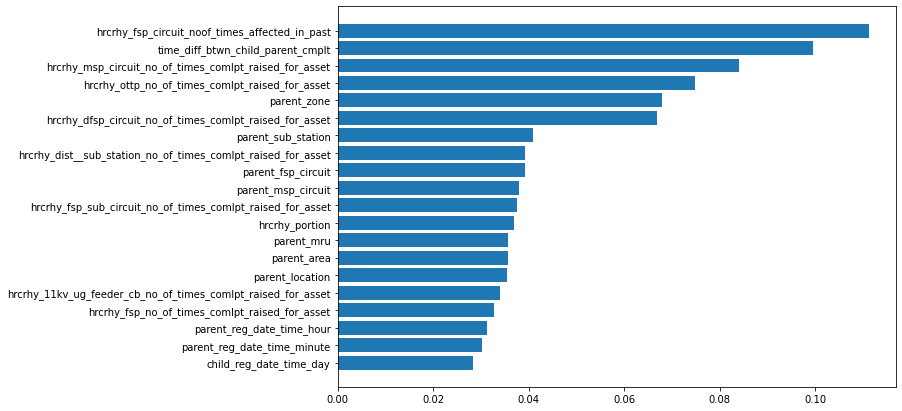

In [111]:
sorted_id = best_model.feature_importances_.argsort()
plt.figure(figsize=(10,7))
plt.barh(X_train.columns[sorted_id],best_model.feature_importances_[sorted_id])


In [112]:
import shap
explainer = shap.TreeExplainer(best_model)

In [130]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0],X_test)

NameError: name 'X_test' is not defined

In [131]:
# import joblib
# joblib.dump(best_model,"best_model.joblib")

In [132]:
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import SVC

# best_model = OneVsRestClassifier(SVC()).fit(X_train,y_train)

## Train Performance

In [133]:
label_list = y_train.unique().tolist()
label_list.sort()
label_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]

Accuracy Score : 0.9885178923640462
recall:  0.9885178923640462
f1_scr:  0.988478549284225
precision_score:  0.9887184305194653
Classification Report 
              precision    recall  f1-score   support

           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00       652
           7       1.00      1.00      1.00       140
           8       0.98      1.00      0.99      6690
           9       1.00      1.00      1.00       320
          10       1.00      1.00      1.00        40
          11       1.00      1.00      1.00       274
          12       1.00      1.00      1.00        68
          13       1.00      0.98      0.99      1344
          14       1.00      0.95      0.97      1722
          16       1.00      1.00      1.00       464
          17       1.00      1.00      1.00       214
          18       1.00      0.98      0.99      2014
          19       1.00      1.00      1.00       134
          20       1.00      1.00     

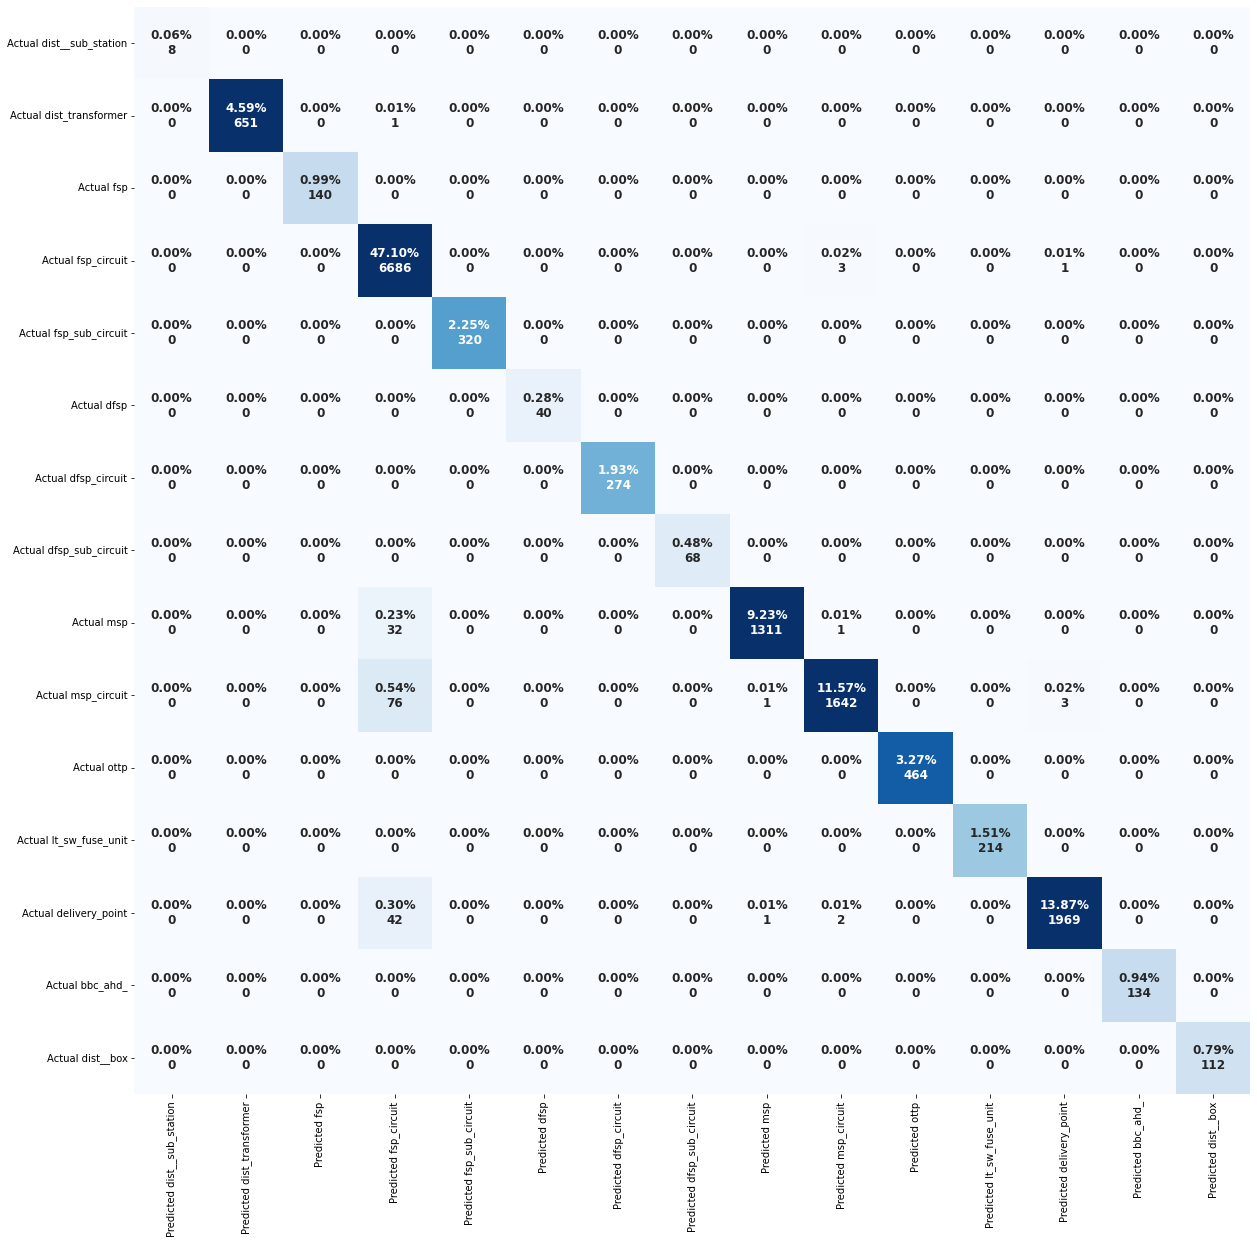

In [134]:
performance_matices(best_model, X_train, y_train, label_list)


## Validation Performance

In [135]:
label_list = y_val.unique().tolist()
label_list.sort()
label_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]

Accuracy Score : 0.9750132908027644
recall:  0.9750132908027644
f1_scr:  0.9750573292576056
precision_score:  0.9757936344164422
Classification Report 
              precision    recall  f1-score   support

           5       1.00      1.00      1.00         4
           6       1.00      0.89      0.94       340
           7       1.00      0.97      0.98        87
           8       0.98      0.98      0.98      3624
           9       1.00      0.98      0.99       174
          10       1.00      1.00      1.00        20
          11       0.99      0.99      0.99       138
          12       1.00      1.00      1.00        36
          13       1.00      0.96      0.98       720
          14       0.96      0.96      0.96       890
          16       1.00      1.00      1.00       232
          17       1.00      1.00      1.00       114
          18       0.92      0.99      0.95      1021
          19       1.00      1.00      1.00        67
          20       1.00      1.00    

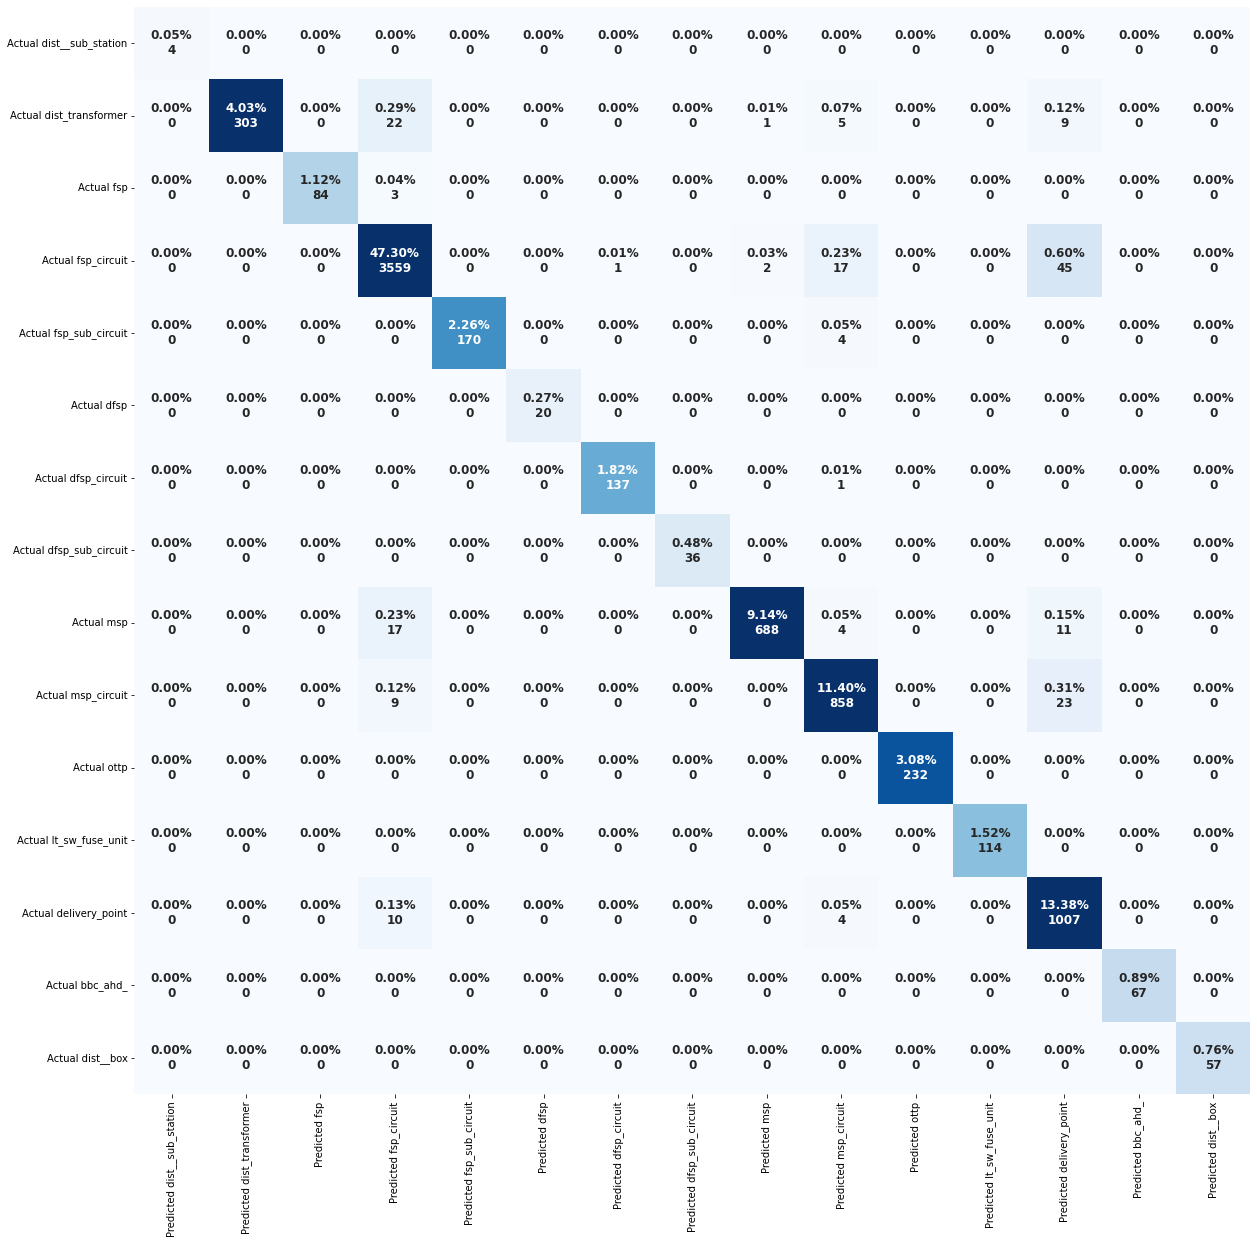

In [136]:
performance_matices(best_model, X_val, y_val, label_list)

## Test Performance

In [137]:
test_data.shape

(2383, 133)

In [147]:
test_data1 = test_data[test_data.groupby(['parent_complaint_number'])['child_partner_no'].transform('count')>cmplnt_fmly_crtcl_mass]

In [148]:
test_data1.shape

(1301, 133)

In [149]:
X_test = test_data1[X_val.columns]
y_test = test_data1[label]

In [150]:
label_list = y_test.unique().tolist()
label_list.sort()
label_list

[6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]

Accuracy Score : 0.47886241352805536
recall:  0.47886241352805536
f1_scr:  0.38917463074352804
precision_score:  0.3458103756793524
Classification Report 
              precision    recall  f1-score   support

           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00         4
           8       0.54      0.88      0.67       611
           9       0.00      0.00      0.00        49
          10       0.00      0.00      0.00         8
          11       0.73      0.26      0.38        31
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00       140
          14       0.27      0.22      0.24       171
          16       0.39      0.48      0.43        33
          17       0.00      0.00      0.00        15
          18       0.30      0.19      0.23       115
          19       0.00      0.00      0.00        15
          20       0.25      0.25      0.25        12

    accuracy                     

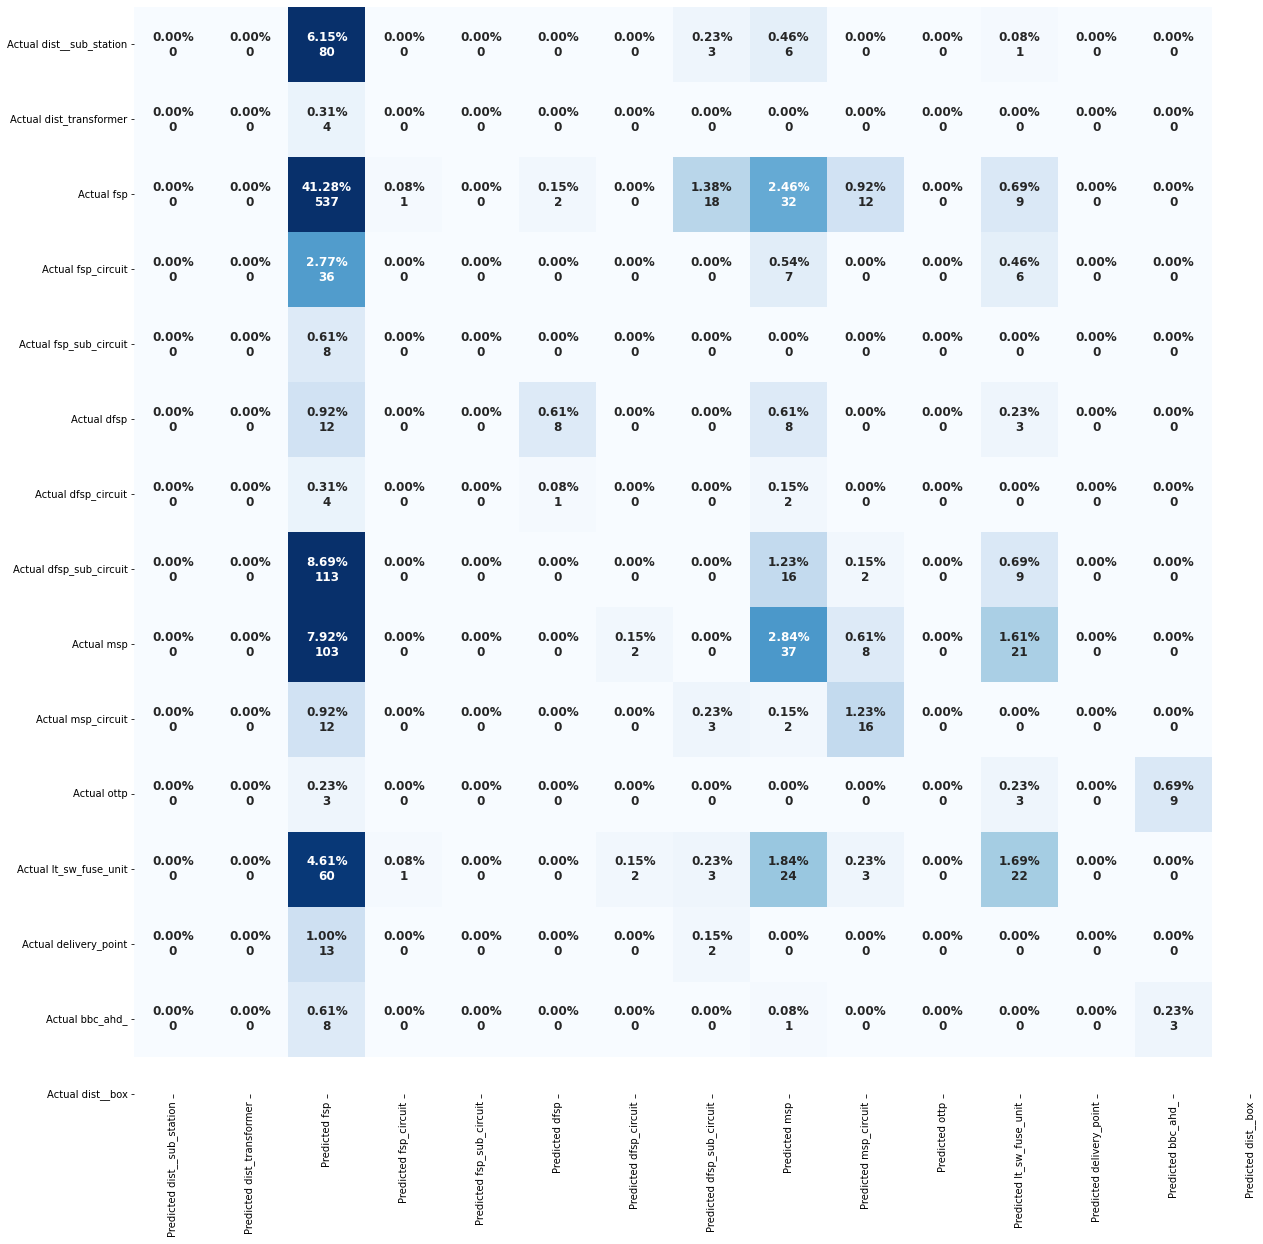

In [151]:
y_test_pred = best_model.predict(X_test)
performance_matices(best_model, X_test, y_test,label_list)

In [153]:
test_result = test_data1.copy()
test_result['flg_actual'] = y_test
test_result['flg_predict'] = y_test_pred

In [154]:
test_result[test_result['flg_actual']!=8].shape

(690, 135)

In [155]:
test_result[test_result['flg_actual']==8].shape

(611, 135)

In [156]:
test_result[test_result['flg_predict']!=8].shape

(308, 135)

In [157]:
test_result[test_result['flg_predict']==8].shape

(993, 135)

In [179]:
test_result[test_result['parent_complaint_number']==1006538854][top+['flg_actual','flg_predict','parent_complaint_number','parent_business_partner','child_partner_no']]

child_reg_date_time_day  parent_fsp_circuit  \
42194                       27               272.0   
42195                       27               272.0   
42196                       27               272.0   
42197                       27               272.0   
42198                       27               272.0   
42199                       27               272.0   

       time_diff_btwn_child_parent_cmplt  \
42194                               90.0   
42195                               91.0   
42196                               92.0   
42197                              106.0   
42198                              134.0   
42199                              149.0   

       hrcrhy_fsp_circuit_noof_times_affected_in_past  \
42194                                            -1.0   
42195                                            -1.0   
42196                                            -1.0   
42197                                            -1.0   
42198                                            -1.0   
42199                                            -1.0   

       hrcrhy_ottp_no_of_times_comlpt_raised_for_asset  \
42194                                            59376   
42195                                            59376   
42196                                            59376   
42197                                            59376   
42198                                            59376   
42199                                            59376   

       parent_reg_date_time_minute  parent_location  \
42194                           25               32   
42195                           25               32   
42196                           25               32   
42197                           25               32   
42198                           25               32   
42199                           25               32   

       hrcrhy_fsp_no_of_times_comlpt_raised_for_asset  \
42194                                              27   
42195                                              27   
42196                                              27   
42197                                              27   
42198                                              27   
42199                                              27   

       hrcrhy_msp_circuit_no_of_times_comlpt_raised_for_asset  \
42194                                                  1        
42195                                                  1        
42196                                                  1        
42197                                                  1        
42198                                                  1        
42199                                                  1        

       hrcrhy_fsp_sub_circuit_no_of_times_comlpt_raised_for_asset  \
42194                                                 27            
42195                                                 27            
42196                                                 27            
42197                                                 27            
42198                                                 27            
42199                                                 27            

       hrcrhy_dfsp_circuit_no_of_times_comlpt_raised_for_asset  parent_zone  \
42194                                                 27                  7   
42195                                                 27                  7   
42196                                                 27                  7   
42197                                                 27                  7   
42198                                                 27                  7   
42199                                                 27                  7   

       parent_sub_station  parent_area  hrcrhy_portion  \
42194               246.0         52.0              58   
42195               246.0         52.0              58   
42196               246.0         52.0              58   


In [ ]:
temp = pd.DataFrame(test_result[test_result['flg_predict']!=8].groupby('parent_complaint_number')['parent_business_partner'].count())
temp[temp['parent_business_partner']>=3]